In [2]:
import numpy as np
from numpy.random import randn
from scipy.stats import norm as ndist
from numpy.linalg import norm
from numpy import log, zeros, eye, array
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as MVN

from RWM import RWM
from tangential_hug_functions import Hug, HugTangential

$$
F(\theta_1, \theta_2) = \theta_2^2 + \theta_1^2(\theta_1^2 - 0.5)
$$

$$
\partial_{\theta_1} F(\theta) = 4\theta_1^3 - \theta_1 \qquad \qquad \partial_{\theta_2} F(\theta) = 2\theta_2
$$

In [508]:
dy = 1
dθ = 2
F = lambda θ: θ[1]**2 + (θ[0]**2) * (θ[0]**2 - 0.5)
y_obs = 1

In [509]:
sample_prior   = lambda: randn(2)
prior_density  = lambda x: MVN(zeros(2), eye(2)).pdf(x)
prior_log_dens = lambda x: MVN(zeros(2), eye(2)).logpdf(x)
prior_neg_log_dens = lambda x: -prior_log_dens(x)
grad_log_prior = lambda x: -x
grad_F = lambda θ: array([4*θ[0]**3 - θ[0], 2*θ[1]])

In [103]:
def log_posterior(θ, y=y_obs, σ=σ):
    return prior_log_dens(θ) - norm(y - F(θ))**2 / (2*σ**2) - 1*log(σ)

def grad_log_post(θ, y=y_obs, σ=σ):
    return grad_log_prior(θ) + (y - F(θ))*grad_F(θ) / (σ**2)

In [88]:
θ0 = sample_prior()
N = 50000

In [89]:
σ1 = 0.5
ϵ1 = σ1
log_post1 = lambda θ: log_posterior(θ, σ=σ1)
samples1, acc1 = RWM(θ0, ϵ1, N, log_post1)

In [90]:
σ2 = 0.1
ϵ2 = σ2
log_post2 = lambda θ: log_posterior(θ, σ=σ2)
samples2, acc2 = RWM(θ0, ϵ2, N, log_post2)

In [91]:
σ3 = 0.02
ϵ3 = σ3
log_post3 = lambda θ: log_posterior(θ, σ=σ3)
samples3, acc3 = RWM(θ0, ϵ3, N, log_post3)

In [134]:
q = MVN(zeros(2), eye(2))
T = 5.0
B = 5
grad_log_post1 = lambda θ: grad_log_post(θ, σ=σ1)
grad_log_post2 = lambda θ: grad_log_post(θ, σ=σ2)
grad_log_post3 = lambda θ: grad_log_post(θ, σ=σ3)
samples_hug3, acc_hug3 = Hug(θ0, T, B, 2000, q, log_post3, grad_log_post3)

In [151]:
samples_thug3, acc_thug3 = HugTangential(θ0, T, B, 2000, 0.9, q, log_post3, grad_log_post3)

In [152]:
acc_thug3.mean() * 100

23.7

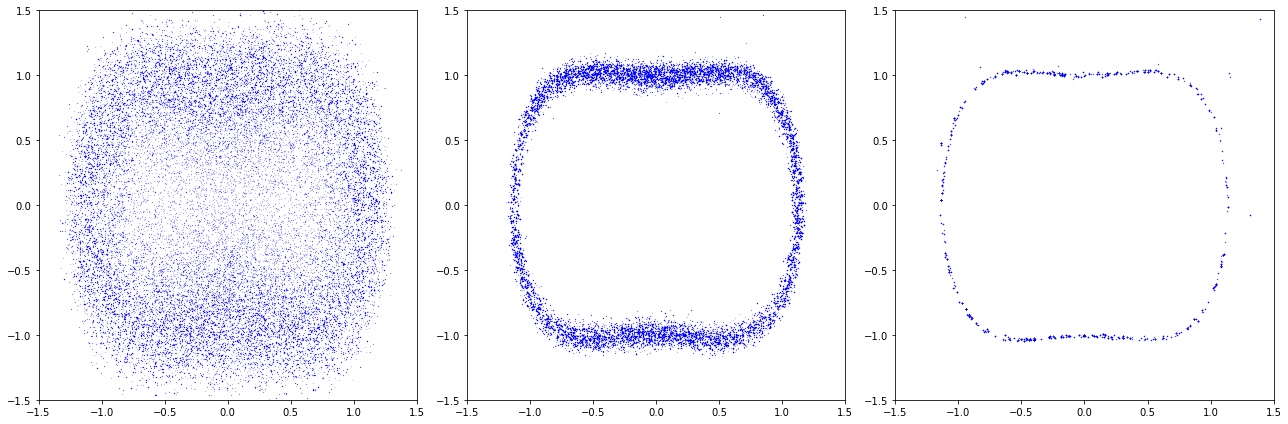

In [153]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))
color = 'blue'

#_ = ax[0].hist2d(*samples1.T, bins=40, density=True, cmap='Blues')
ax[0].scatter(*samples1.T, color=color, s=0.01)
ax[0].set_xlim([-1.5, 1.5])
ax[0].set_ylim([-1.5, 1.5])

ax[1].scatter(*samples2.T, color=color, s=0.01)
ax[1].set_xlim([-1.5, 1.5])
ax[1].set_ylim([-1.5, 1.5])

#ax[2].scatter(*samples3.T, color=color, s=0.01)
ax[2].scatter(*samples_thug3.T, color=color, s=0.1)
ax[2].set_xlim([-1.5, 1.5])
ax[2].set_ylim([-1.5, 1.5])
plt.tight_layout()
plt.show()

# Graham Notebook

In [1]:
import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

In [2]:
import time
import inspect
from functools import partial
from itertools import product
import symnum.numpy as snp
from symnum import (
    numpify, named_array, jacobian, grad, 
    vector_jacobian_product, matrix_hessian_product)
import numpy as np
import sympy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from ipywidgets import interact, fixed, Dropdown
from IPython.display import Javascript
import arviz
import mici

In [3]:
import os
ON_BINDER = 'BINDER_SERVICE_HOST' in os.environ

plt.rcParams.update({
    'mathtext.fontset': 'cm',
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 10,
    'axes.linewidth': 0.5,
    'lines.linewidth': 1.,
    'axes.labelpad': 2.,
    'figure.dpi': 100,
    'figure.figsize': (6, 6),
    'legend.frameon': False,
    'animation.html': 'html5'
})

dens_cmap = mcolors.LinearSegmentedColormap.from_list(
    'whiteblue', [np.array((1.000, 1.000, 1.000, 1.)),
                  np.array((0.419, 0.682, 0.840, 1.)),
                  np.array((0.031, 0.188, 0.420, 1.))])

seed = 20200310
rng = np.random.default_rng(seed)

In [4]:
ON_COLAB = False
# To always use interactive plots by default comment the first line below 
# and uncomment the second
default_plot_type = 'Static' if not (ON_COLAB or ON_BINDER) else 'Interactive'
# default_plot_type = 'Interactive'
        
plot_type = Dropdown(value=default_plot_type, description='Plot type', 
                 options=['Interactive', 'Static'])

def interact_or_grid(plot_function, figsize=(12, 12), subplot_kw=None, **kwargs):
    display(plot_type)
    grid_params = kwargs.pop('grid_params', ('y', 'σ'))
    params = {k: v[0] if plot_type.value == 'Interactive' else v[1] 
              for k, v in kwargs.items()}
    if plot_type.value == 'Interactive':
        interact(plot_function, **params, ax=fixed(None))
    else:
        fig, axes = plt.subplots(
            len(params[grid_params[0]]), len(params[grid_params[1]]), 
            figsize=figsize, subplot_kw=subplot_kw)
        grid_param_0_vals = params.pop(grid_params[0])
        grid_param_1_vals = params.pop(grid_params[1])
        for (p0, p1), ax in zip(product(grid_param_0_vals, grid_param_1_vals), 
                                axes.flat):
            plot_function(
                **{grid_params[0]: p0, grid_params[1]: p1}, **params, ax=ax)
            ax.set_title(fr'${grid_params[0]}={p0}, {grid_params[1]}={p1}$')
        fig.tight_layout()

In [5]:
dim_θ = 2
dim_y = 1

@numpify(dim_θ)
def forward_func(θ):
    return snp.array([θ[1]**2 + 3 * θ[0]**2 * (θ[0]**2 - 1)])

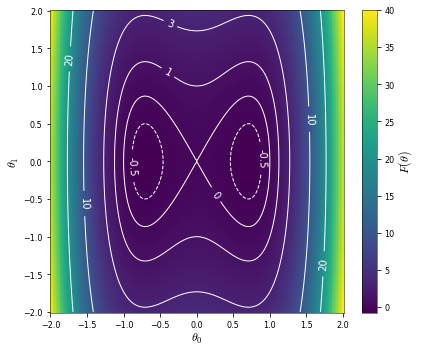

In [6]:
θ_grid = np.stack(
    np.meshgrid(np.linspace(-2, 2, 201), np.linspace(-2, 2, 201))
)
f_grid = forward_func(θ_grid)
fig, ax = plt.subplots(figsize=(6, 5))
mesh = ax.pcolormesh(θ_grid[0], θ_grid[1], f_grid[0])
cset = ax.contour(θ_grid[0], θ_grid[1], f_grid[0], [-0.5, 0, 1, 3, 10, 20], colors='white')
ax.clabel(cset, fmt='%.2g')
cax = fig.colorbar(mesh)
_ = cax.set_label(r'$F(\mathbf{\theta})$')
_ = ax.set(xlabel=r'$\theta_0$', ylabel=r'$\theta_1$')
fig.tight_layout()

In [7]:
@numpify(dim_θ, None, None)
def neg_log_posterior_dens(θ, σ, y):
    return (snp.sum(θ**2, 0) + snp.sum((y - forward_func(θ))**2, 0) / σ**2) / 2

In [8]:
def create_fig_if_none(ax, **fig_kw):
    if ax is None:
        fig, ax = plt.subplots(**fig_kw)
    else:
        fig = ax.figure
    return fig, ax

def plot_posterior_density(σ=0.1, y=1., ax=None):
    fig, ax = create_fig_if_none(ax)
    ax.pcolormesh(θ_grid[0], θ_grid[1],
                  np.exp(-neg_log_posterior_dens(θ_grid, σ, y)), 
                  cmap=dens_cmap)
    ax.set(xlabel=r'$\theta_0$', ylabel=r'$\theta_1$')
    return fig, ax

# my edit start

In [11]:
θ_grid.shape

(2, 201, 201)

In [17]:
np.sum(θ_grid**2, 0).shape

(201, 201)

In [26]:
np.sum((1.0 - forward_func(θ_grid))**2, 0).shape

(201, 201)

In [ ]:
snp.sum((y - forward_func(θ))**2, 0) / σ**2) / 2

In [15]:
neg_log_posterior_dens(θ_grid, 0.02, 1.0)

(201, 201)

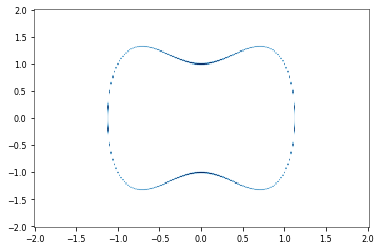

In [27]:
fig, ax = plt.subplots()
ax.pcolormesh(θ_grid[0], θ_grid[1], np.exp(-neg_log_posterior_dens(θ_grid, 0.02, 1.0)), cmap=dens_cmap)

In [ ]:
θ_grid

# my edit end

Dropdown(description='Plot type', index=1, options=('Interactive', 'Static'), value='Static')

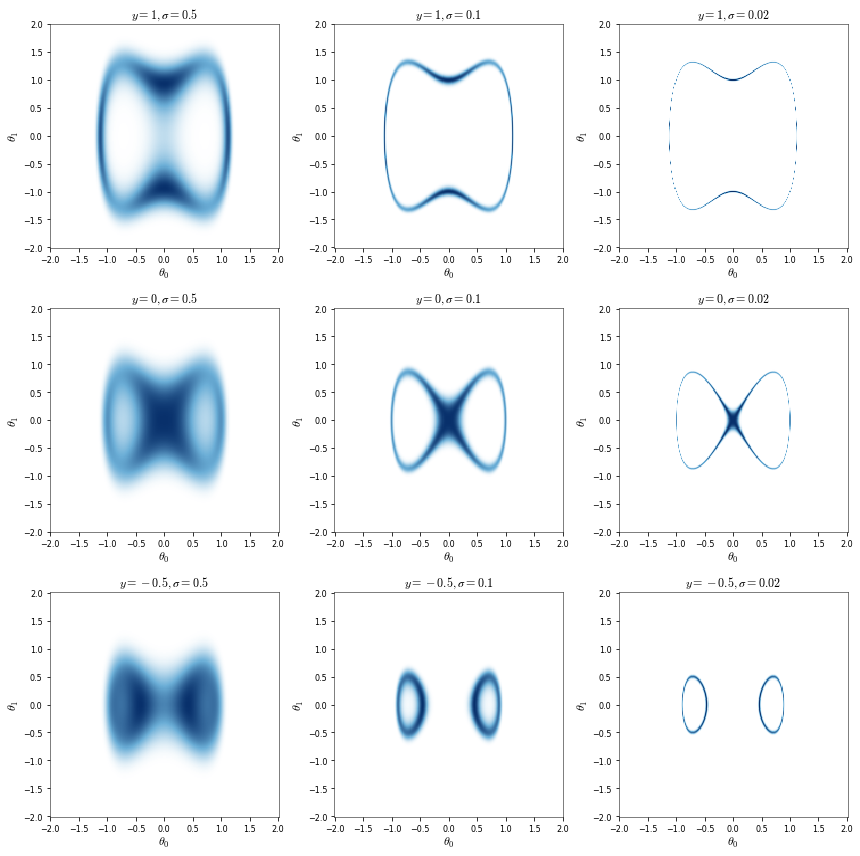

In [9]:
interact_or_grid(
    plot_posterior_density, figsize=(12, 12),
    σ=[(0.02, 1., 0.02), (0.5, 0.1, 0.02)], 
    y=[(-0.5, 2., 0.1), (1, 0, -0.5)])

In [14]:
def split_into_integer_parts(n, m):
    return [round(n / m)] * (m - 1) + [n - round(n / m) * (m - 1)]

def grid_on_interval(interval, n_points, cosine_spacing=False):
    if cosine_spacing:
        # Use non-linear spacing with higher density near endpoints
        ts =  ((1 + np.cos(np.linspace(0, 1, n_points) * np.pi)) / 2)
    else:
        ts = np.linspace(0, 1, n_points)
    # If open interval space over range [left + eps, right - eps]
    eps = 10 * np.finfo(np.float64).eps
    left = (float(interval.left) + eps if interval.left_open 
            else float(interval.left))
    right = (float(interval.right) - eps if interval.right_open 
             else float(interval.right))
    return left + ts * (right - left)


In [15]:
def solve_for_limiting_manifold(y, n_points=200, cosine_spacing=False):
    assert n_points % 2 == 0, 'n_points must be even'
    θ = named_array('θ', 2)
    # solve F(θ) = y for θ[1] in terms of θ[0]
    θ_1_gvn_θ_0 = sympy.solve(forward_func(θ)[0] - y, θ[1])
    # find interval(s) over which θ[0] gives real θ[1] solutions
    θ_0_range = sympy.solveset(
        θ_1_gvn_θ_0[0]**2 > 0, θ[0], domain=sympy.Reals)
    θ_0_intervals = (
        θ_0_range.args if isinstance(θ_0_range, sympy.Union) 
        else [θ_0_range])
    # create  grid of values over valid θ[0] interval(s)
    n_intervals = len(θ_0_intervals)
    θ_0_grids = [
        grid_on_interval(intvl, n_pt + 1, cosine_spacing)
        for intvl, n_pt in zip(
            θ_0_intervals, 
            split_into_integer_parts(n_points // 2, n_intervals))]
    # generate NumPy function to calculate θ[1] in terms of θ[0]
    solve_func = sympy.lambdify(θ[0], θ_1_gvn_θ_0)
    manifold_points = []
    for θ_0_grid in θ_0_grids:
        # numerically calculate +/- θ[1] solutions over θ[0] grid
        θ_1_grid_neg, θ_1_grid_pos = solve_func(θ_0_grid)
        # stack θ[0] and θ[1] values in to 2D array in anticlockwise order
        manifold_points.append(np.stack([
            np.concatenate([θ_0_grid, θ_0_grid[-2:0:-1]]),
            np.concatenate([θ_1_grid_neg, θ_1_grid_pos[-2:0:-1]])
        ], -1))
    return manifold_points

Dropdown(description='Plot type', index=1, options=('Interactive', 'Static'), value='Static')

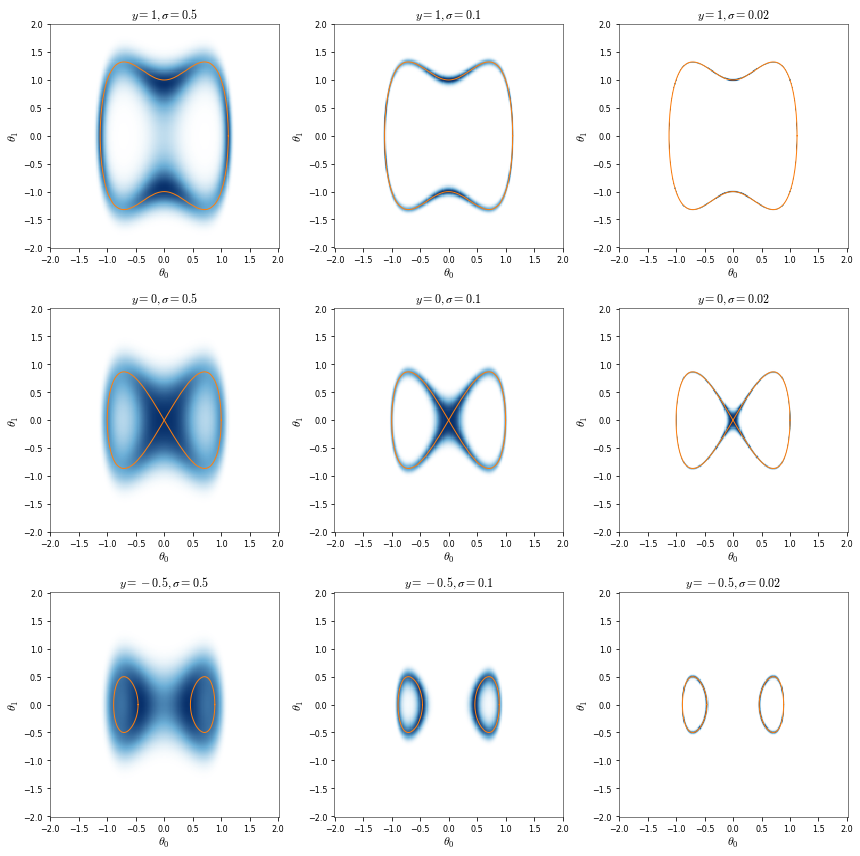

In [16]:
def plot_limiting_manifold(y, ax=None, num_points=200):
    manifold_points = solve_for_limiting_manifold(
        y, num_points, cosine_spacing=True)
    fig, ax = create_fig_if_none(ax)
    # repeat first point to close loop by duplicating index
    for component in manifold_points:
        indices = np.arange(component.shape[0] + 1) % component.shape[0]
        line, = ax.plot(component[indices, 0], 
                        component[indices, 1], '-', color='C1', lw=1.)
    return fig, ax, line

def plot_posterior_density_and_limiting_manifold(σ=0.1, y=1, ax=None):
    fig, ax = plot_posterior_density(σ, y, ax)
    plot_limiting_manifold(y=y, ax=ax)
    return fig, ax

interact_or_grid(
    plot_posterior_density_and_limiting_manifold, figsize=(12, 12),
    σ=[(0.02, 1.0, 0.02), (0.5, 0.1, 0.02)], 
    y=[(-0.5, 2., 0.1), (1, 0, -0.5)])

In [17]:
grad_neg_log_posterior_dens = grad(neg_log_posterior_dens)

Dropdown(description='Plot type', index=1, options=('Interactive', 'Static'), value='Static')

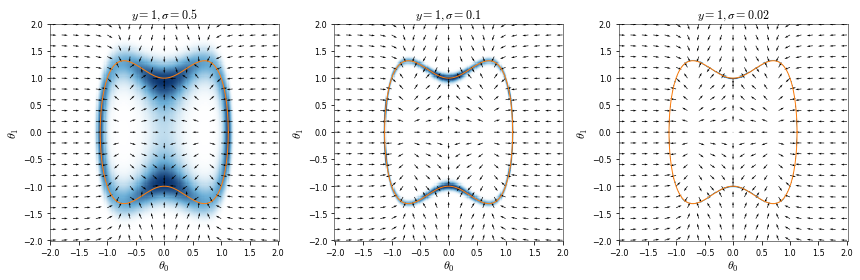

In [18]:
def plot_posterior_density_and_grad_field(σ=0.1, y=1, ax=None):
    fig, ax = plot_posterior_density_and_limiting_manifold(σ, y, ax)
    θ_grid_grad = θ_grid[:, ::10, ::10]
    grad_field = -grad_neg_log_posterior_dens(θ_grid_grad, σ, y)
    grad_field_norm = np.sum(grad_field**2, 0)**0.5
    grad_field[:, grad_field_norm >= 1e-8] /= grad_field_norm[grad_field_norm >= 1e-8]
    ax.quiver(*θ_grid_grad, *(grad_field), angles='xy')
    return fig, ax

interact_or_grid(
    plot_posterior_density_and_grad_field, figsize=(12, 4),
    σ=[(0.02, 1., 0.02), (0.5, 0.1, 0.02)], y=[(-0.5, 2., 0.1), (1,)])

In [19]:
grad_and_val_neg_log_posterior_dens = grad(
    neg_log_posterior_dens, return_aux=True)

In [20]:
σ = 0.1
y = 1

system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
    grad_neg_log_dens=partial(grad_and_val_neg_log_posterior_dens, σ=σ, y=y))

In [21]:
def print_attributes(obj):
    for attr in dir(obj):
        if attr[0] != '_':
            print(f'{attr}: {inspect.getdoc(getattr(obj, attr)).splitlines()[0]}')

print_attributes(system)

dh1_dpos: Derivative of `h1` Hamiltonian component with respect to position.
dh2_dmom: Derivative of `h2` Hamiltonian component with respect to momentum.
dh2_flow_dmom: Derivatives of `h2_flow` flow map with respect to input momentum.
dh_dmom: Derivative of Hamiltonian with respect to momentum.
dh_dpos: Derivative of Hamiltonian with respect to position.
grad_neg_log_dens: Derivative of negative log density with respect to position.
h: Hamiltonian function for system.
h1: Hamiltonian component depending only on position.
h1_flow: Apply exact flow map corresponding to `h1` Hamiltonian component.
h2: Hamiltonian component depending on momentum and optionally position.
h2_flow: Apply exact flow map corresponding to `h2` Hamiltonian component.
metric: Matrix representing identity operator on a vector space.
neg_log_dens: Negative logarithm of unnormalized density of target distribution.
sample_momentum: Sample a momentum from its conditional distribution given a position.


In [22]:
state = mici.states.ChainState(
    pos=rng.standard_normal(dim_θ), mom=None, dir=1)
state.mom = system.sample_momentum(state, rng)

In [23]:
integrator = mici.integrators.LeapfrogIntegrator(system, step_size=0.05)

In [24]:
n_step = 2
state_init = state.copy()
display(state)
for s in range(n_step):
    state = integrator.step(state)
    display(state)
state.dir *= -1
display(state)
for s in range(n_step):
    state = integrator.step(state)
    display(state)
state.dir *= -1
assert (np.allclose(state.pos, state_init.pos) and 
        np.allclose(state.mom, state_init.mom))

ChainState(
 pos=[-0.329414   -1.46108452],
 mom=[-0.98537164  0.25382918],
 dir=1)

ChainState(
 pos=[-0.54164252 -1.13807594],
 mom=[-3.13412876  4.62955666],
 dir=1)

ChainState(
 pos=[-0.64282688 -0.99812886],
 mom=[-0.78410153 -0.82501368],
 dir=1)

ChainState(
 pos=[-0.64282688 -0.99812886],
 mom=[-0.78410153 -0.82501368],
 dir=-1)

ChainState(
 pos=[-0.54164252 -1.13807594],
 mom=[-3.13412876  4.62955666],
 dir=-1)

ChainState(
 pos=[-0.329414   -1.46108452],
 mom=[-0.98537164  0.25382918],
 dir=-1)

In [25]:
sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=20)

In [26]:
final_state, trace, stats = sampler.sample_chain(n_iter=2000, init_state=state)

Chain 1/1: 100%|██████████|2000/2000 [00:00<00:00, 2687.40it/s, accept_stat=0.672]

<string>:8: RuntimeWarning: overflow encountered in double_scalars
<string>:9: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/mici/systems.py:111: RuntimeWarning: invalid value encountered in subtract
  state.mom -= dt * self.dh1_dpos(state)
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:5: RuntimeWarning: overflow encountered in double_scalars
<string>:4: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/mici/systems.py:257: RuntimeWarning: overflow encountered in matmul
  return 0.5 * state.mom @ self.dh2_dmom(state)
<string>:6: RuntimeWarning: overflow encountered in double_scalars


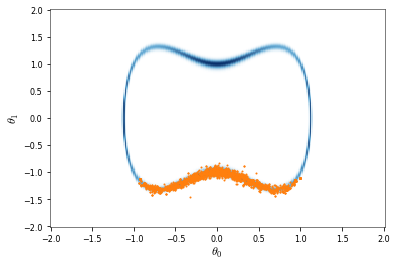

In [27]:
fig, ax = plot_posterior_density(σ=σ, y=y)
ax.plot(*trace['pos'].T, '.', ms=2, color='C1')

In [28]:
def simulate_proposal(state, system, integrator, rng, n_step=10):
    state.mom = system.sample_momentum(state, rng)
    θ_traj = np.full((n_step + 1, dim_θ), np.nan)
    θ_traj[0] = state.pos[:dim_θ]
    h_init = system.h(state)
    try:
        for s in range(n_step):
            state = integrator.step(state)
            if abs(system.h(state) - h_init) > 1000:
                raise mici.errors.HamiltonianDivergenceError
            θ_traj[s + 1] = state.pos[:dim_θ]
        accepted = rng.uniform() < np.exp(h_init - system.h(state))
    except mici.errors.Error as e:
        accepted = False
    return θ_traj, accepted

In [29]:
def plot_trajectory(ax, θ_traj, accepted):
    ax.plot(θ_traj[:, 0], θ_traj[:, 1], '-o', ms=2, lw=1, 
            color=('limegreen' if accepted else 'red'))
    ax.plot(θ_traj[0, 0], θ_traj[0, 1], 'o', 
            color=('limegreen' if accepted else 'red'))

In [30]:
def plot_hmc_proposals(σ=0.1, ϵ=0.1, y=1, n_step=20, n_particle=4, ax=None):
    system = mici.systems.EuclideanMetricSystem(
                neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
                grad_neg_log_dens=partial(grad_neg_log_posterior_dens, σ=σ, y=y))
    integrator = mici.integrators.LeapfrogIntegrator(system, step_size=ϵ)
    states = [mici.states.ChainState(pos=θ, mom=None, dir=1) 
              for θ in np.concatenate(solve_for_limiting_manifold(y, n_particle))]
    fig, ax = plot_posterior_density(σ, y, ax)
    rng = np.random.default_rng(seed)
    for state in states:
        plot_trajectory(ax, *simulate_proposal(
            state, system, integrator, rng, n_step))

Dropdown(description='Plot type', index=1, options=('Interactive', 'Static'), value='Static')

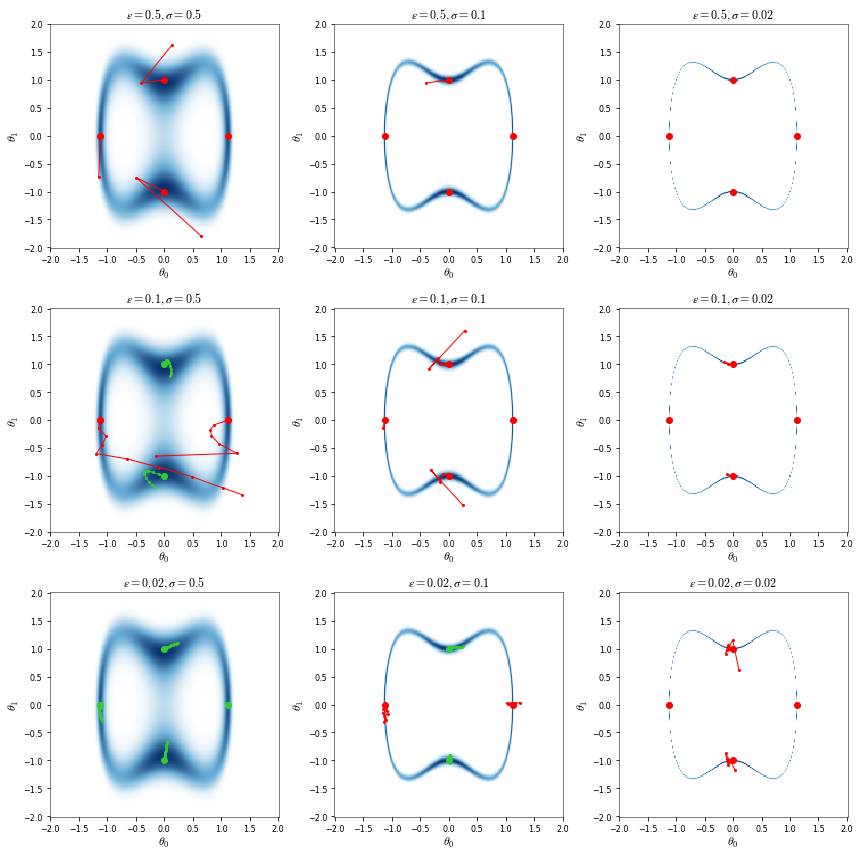

In [31]:
interact_or_grid(
    plot_hmc_proposals, 
    σ=[(0.02, 1., 0.02), (0.5, 0.1, 0.02)], 
    ϵ=[(0.02, 1., 0.02), (0.5, 0.1, 0.02)], 
    y=[(-0.5, 2.), y], 
    n_step=[(10, 100, 10), 10], 
    n_particle=[(4, 10, 2), 4],
    grid_params=('ε', 'σ')
)

# HMC

In [32]:
n_sample = 20
n_chain = 4
n_step = 20

σ_grid = np.logspace(-5, 0, 11)
ϵ_grid = np.logspace(-5, 0, 11)

θ_inits = np.concatenate(solve_for_limiting_manifold(y, n_chain))

hmc_av_accept_probs = np.full((σ_grid.shape[0], ϵ_grid.shape[0]), np.nan)

In [33]:
_ = np.seterr(invalid='ignore', over='ignore')

In [34]:
n_sample = 50
n_chain = 10
hmc_av_accept_probs = np.full((σ_grid.shape[0], ϵ_grid.shape[0]), np.nan)
with mici.progressbars.ProgressBar(
        list(enumerate(product(σ_grid, ϵ_grid))), 'Completed') as pb:
    for (i, (σ, ϵ)), _ in pb:
        system = mici.systems.EuclideanMetricSystem(
            neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
            grad_neg_log_dens=partial(grad_and_val_neg_log_posterior_dens, σ=σ, y=y))
        integrator = mici.integrators.LeapfrogIntegrator(system, step_size=ϵ)
        sampler = mici.samplers.StaticMetropolisHMC(
            system, integrator, rng, n_step=n_step)
        _, _, stats = sampler.sample_chains(
            n_sample, θ_inits, display_progress=False)
        hmc_av_accept_probs.flat[i] = np.concatenate(
            [a for a in stats['accept_stat']]).mean()

Completed: 100%|██████████|121/121 [00:09<00:00, 13.06it/s]

In [35]:
def plot_statistic_heatmap(
        σ_grid, ϵ_grid, statistic_grid, ax=None, title=None, colorbar=True):
    fig, ax = create_fig_if_none(ax, figsize=(5, 4))
    artist = ax.imshow(statistic_grid.T, vmin=0, vmax=1, origin='lower')
    ax.set(xlabel='Noise standard deviation $\sigma$', 
           ylabel='Integrator step size $\epsilon$',
           title=title, aspect=1, 
           xticks=np.arange(σ_grid.shape[0])[::2],
           xticklabels=[f'$10^{{{int(i)}}}$' for i in np.log10(σ_grid[::2])],
           yticks=np.arange(ϵ_grid.shape[0])[::2], 
           yticklabels=[f'$10^{{{int(i)}}}$' for i in np.log10(ϵ_grid[::2])])
    if colorbar:
        fig.colorbar(artist, ax=fig.axes)
    return fig, ax

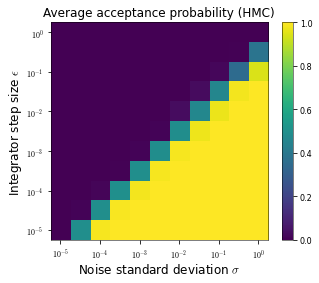

In [36]:
fig, ax = plot_statistic_heatmap(
    σ_grid, ϵ_grid, hmc_av_accept_probs, title='Average acceptance probability (HMC)')

# Riemann-Manifold HMC

In [37]:
@numpify(dim_θ, None)
def metric(θ, σ):
    jac = jacobian(forward_func)(θ)
    return jac.T @ jac / σ**2 + snp.identity(dim_θ)

vjp_metric = vector_jacobian_product(metric, return_aux=True)

Dropdown(description='Plot type', index=1, options=('Interactive', 'Static'), value='Static')

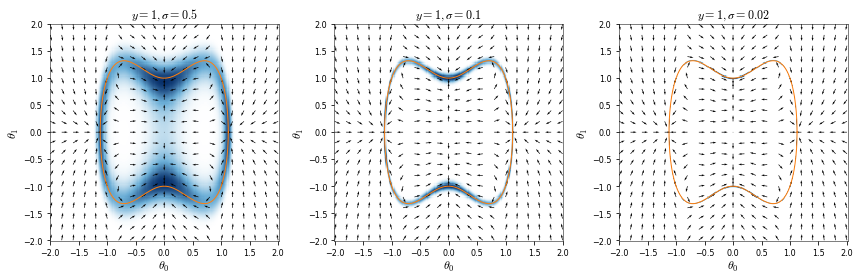

In [38]:
def plot_posterior_density_and_riemannian_grad_field(σ=0.1, y=1., ax=None):
    fig, ax = plot_posterior_density_and_limiting_manifold(σ, y, ax)
    θ_grid_grad = θ_grid[:, ::10, ::10]
    metric_field = metric(θ_grid_grad, σ).reshape(
        (dim_θ, dim_θ, -1)).transpose((2, 0, 1))
    grad_field = -grad_neg_log_posterior_dens(
        θ_grid_grad, σ, y).reshape((dim_θ, -1)).T
    grad_field = np.linalg.solve(metric_field, grad_field).T
    grad_field_norm = np.sum(grad_field**2, 0)**0.5
    grad_field[:, grad_field_norm >= 1e-8] /= (
        grad_field_norm[grad_field_norm >= 1e-8])
    ax.quiver(*θ_grid_grad, *(grad_field), angles='xy')
    return fig, ax

interact_or_grid(
    plot_posterior_density_and_riemannian_grad_field, figsize=(12, 4),
    σ=((0.02, 1., 0.02), (0.5, 0.1, 0.02)), 
    y=((-0.5, 2.5), (1,)))

Dropdown(description='Plot type', index=1, options=('Interactive', 'Static'), value='Static')

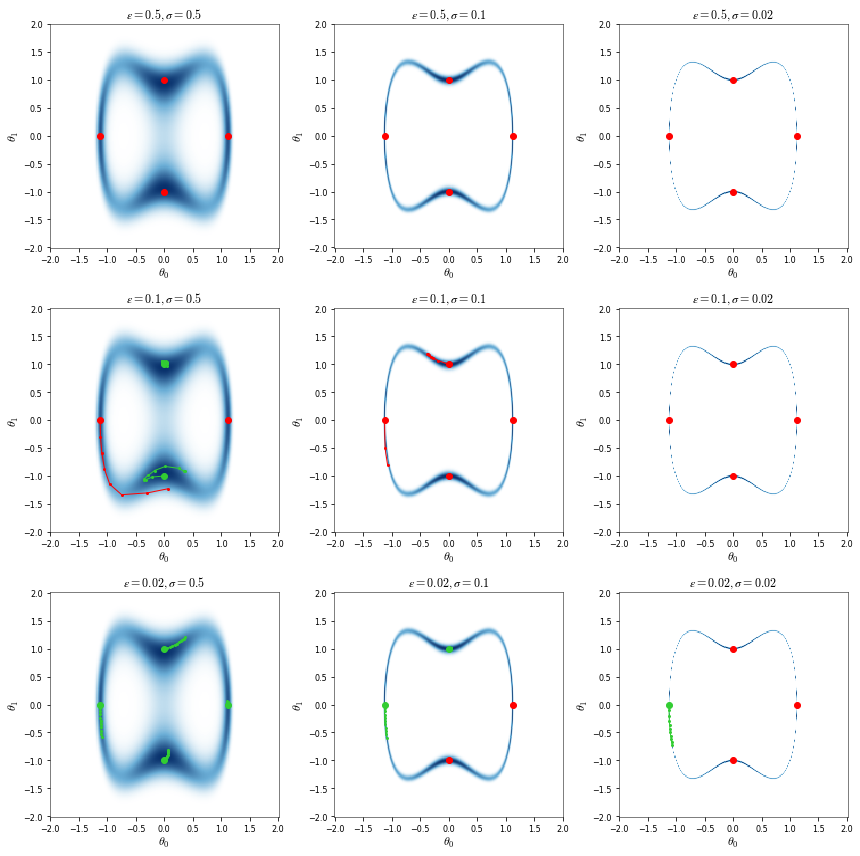

In [39]:
def plot_rmhmc_proposals(σ=0.1, ϵ=0.1, y=1, n_step=20, n_particle=4, ax=None):
    system = mici.systems.DenseRiemannianMetricSystem(
                neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
                grad_neg_log_dens=partial(grad_neg_log_posterior_dens, σ=σ, y=y),
                metric_func=partial(metric, σ=σ), 
                vjp_metric_func=partial(vjp_metric, σ=σ))
    integrator = mici.integrators.ImplicitLeapfrogIntegrator(system, step_size=ϵ)
    states = [mici.states.ChainState(pos=θ, mom=None, dir=1)
              for θ in np.concatenate(solve_for_limiting_manifold(y, n_particle))]
    rng = np.random.default_rng(seed)
    fig, ax = plot_posterior_density(σ, y, ax)
    for state in states:
        plot_trajectory(ax, *simulate_proposal(
            state, system, integrator, rng, n_step))
    
interact_or_grid(
    plot_rmhmc_proposals, 
    σ=[(0.02, 1., 0.02), (0.5, 0.1, 0.02)], 
    ϵ=[(0.02, 1., 0.02), (0.5, 0.1, 0.02)], 
    y=[(-0.5, 2.), y], 
    n_step=[(10, 100, 10), 10], 
    n_particle=[(4, 10, 2), 4],
    grid_params=('ε', 'σ')
)

Completed: 100%|██████████|121/121 [01:55<00:00, 1.05it/s]

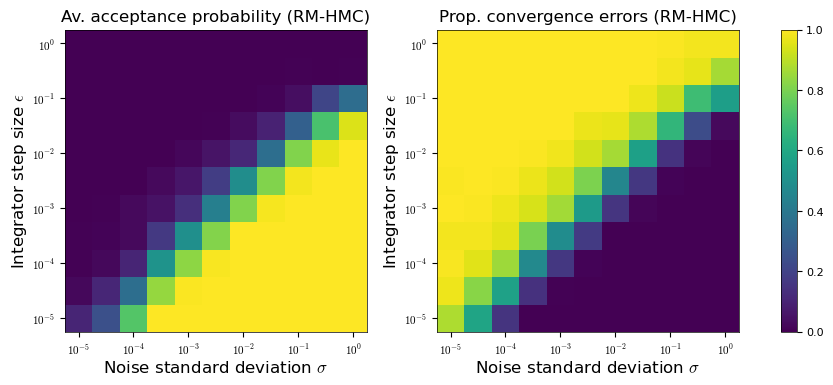

In [638]:
# rmhmc_av_accept_probs, rmhmc_prop_conv_error = np.full(
#     (2, σ_grid.shape[0], ϵ_grid.shape[0]), np.nan) 

# with mici.progressbars.ProgressBar(
#         list(enumerate(product(σ_grid, ϵ_grid))), 'Completed') as pb:
#     for (i, (σ, ϵ)), _ in pb:
#         system = mici.systems.DenseRiemannianMetricSystem(
#             neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
#             grad_neg_log_dens=partial(grad_neg_log_posterior_dens, σ=σ, y=y),
#             metric_func=partial(metric, σ=σ), 
#             vjp_metric_func=partial(vjp_metric, σ=σ))
#         integrator = mici.integrators.ImplicitLeapfrogIntegrator(
#             system, step_size=ϵ)
#         sampler = mici.samplers.StaticMetropolisHMC(
#             system, integrator, rng, n_step=n_step // 2)
#         _, _, stats = sampler.sample_chains(
#             n_sample // 2, θ_inits, n_process=n_chain, display_progress=False)
#         rmhmc_av_accept_probs.flat[i] = np.concatenate(
#             [a for a in stats['accept_stat']]).mean()
#         rmhmc_prop_conv_error.flat[i] = np.concatenate(
#             [a for a in stats['convergence_error']]).mean()

# fig, axes = plt.subplots(1, 2, figsize=(11, 4))
# _ = plot_statistic_heatmap(σ_grid, ϵ_grid, rmhmc_av_accept_probs, ax=axes[0], 
#                            title='Av. acceptance probability (RM-HMC)', colorbar=False)
# _ = plot_statistic_heatmap(σ_grid, ϵ_grid, rmhmc_prop_conv_error, ax=axes[1], 
#                            title='Prop. convergence errors (RM-HMC)')

# C-HMC

In [40]:
@numpify(dim_θ, None, None, None)
def neg_log_lifted_posterior_dens(θ, η, σ, y):
    jac = jacobian(forward_func)(θ)
    return snp.sum(θ**2, 0) / 2 + η**2 / 2 + snp.log(jac @ jac.T + σ**2)[0, 0] / 2

In [41]:
def forward_func_preimage_points(y, n_point):
    t = np.linspace(-1, 1, n_point)
    r, s = -np.cos(np.pi* t), np.sign(t)
    θ_0 = ((1 + (1 + 4 * y / 3)**0.5 - 1e-10) / 2)**0.5 * r
    θ_1 = s * np.sqrt(y - 3 * θ_0**2 * (θ_0**2 - 1))
    return np.stack((θ_0, θ_1), -1)

def manifold_points(σ, y, n_η_vals=50, n_θ_vals=200, η_min_plot=-2., η_max_plot=2.):
    eps = np.finfo(np.float64).eps
    η_grid = np.linspace(η_min_plot + eps,  η_max_plot - eps, n_η_vals)
    θ_points = np.empty((dim_θ,) + (n_η_vals, n_θ_vals))
    η_points = np.tile(η_grid, (n_θ_vals, 1)).T
    for i, η in enumerate(η_grid):
        θ_points[:, i] = forward_func_preimage_points(y - σ * η, n_θ_vals).T
    return θ_points, η_points

Dropdown(description='Plot type', index=1, options=('Interactive', 'Static'), value='Static')

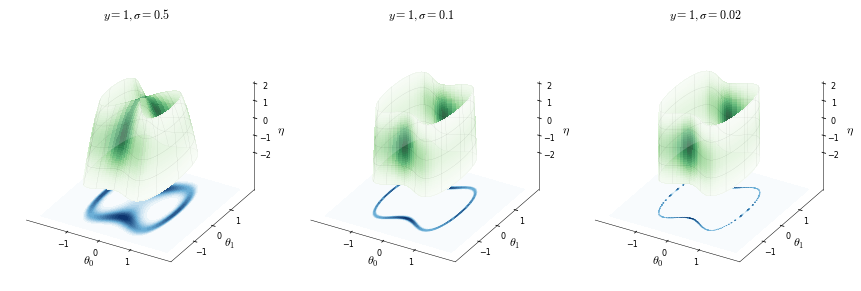

In [42]:
def plot_manifold_and_density(σ=0.1, y=1., azim=-60, elev=30, projection='persp', ax=None):
    fig, ax = create_fig_if_none(ax, subplot_kw={'projection': '3d'})
    θ_points, η_points = manifold_points(σ, y, 40, 80, -2, 2)
    lifted_density_grid = np.exp(-neg_log_lifted_posterior_dens(θ_points, η_points, σ, y))
    density_grid = np.exp(-neg_log_posterior_dens(θ_grid, σ, y))
    # plot lifted density on manifold
    ax.plot_surface(θ_points[0], θ_points[1], η_points, 
                    facecolors=plt.cm.Greens(mcolors.Normalize()(lifted_density_grid)),
                    edgecolor='none', shade=False, cstride=1, rstride=1, 
                    antialiased=False, linewidth=0.0)
    # plot grid 'overlay' over manifold to make shape clearer
    ax.plot_surface(θ_points[0], θ_points[1], η_points, alpha=0.2, color='w',
                    edgecolor=(0, 0, 0, 1), shade=False, cstride=5, rstride=10, 
                    antialiased=True, linewidth=0.1)
    # plot density on original space as filled contour plot below manifold
    ax.contourf(θ_grid[0], θ_grid[1], density_grid, 20, offset=-4, cmap=dens_cmap)
    ax.set(xlabel=r'$\theta_0$', ylabel=r'$\theta_1$', zlabel=r'$\eta$',
           xticks=[-1, 0, 1], yticks=[-1, 0, 1], zticks=[-2, -1, 0, 1, 2],
           zlim=(-4, 2), proj_type=projection)
    ax.tick_params(axis='both', which='major', pad=-2)
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.labelpad = -5
        axis.pane.fill = False
        axis.set_rotate_label(False)
        axis.pane.set_edgecolor('w')
    ax.grid(False)
    ax.view_init(elev, azim)

interact_or_grid(
    plot_manifold_and_density, figsize=(12, 4), subplot_kw={'projection': '3d'},
    σ=[(0.02, 0.5, 0.08), (0.5, 0.1, 0.02)], 
    y=[fixed(1), (1,)], 
    azim=[(-180, 180, 30), -60],
    elev=[(0, 90, 15), 30],
    projection=([('Perspective', 'persp'), ('Orthogonal', 'ortho')], 'ortho'))

In [43]:
@numpify(dim_θ + dim_y)
def neg_log_prior_dens(q):
    return snp.sum(q**2) / 2

grad_neg_log_prior_dens = grad(neg_log_prior_dens)

@numpify(dim_θ + dim_y, None, None)
def constr(q, σ, y):
    θ, η = q[:dim_θ], q[dim_θ:]
    return forward_func(θ) + σ * η - y

jacob_constr = jacobian(constr, return_aux=True)
mhp_constr = matrix_hessian_product(constr, return_aux=True)

Dropdown(description='Plot type', index=1, options=('Interactive', 'Static'), value='Static')

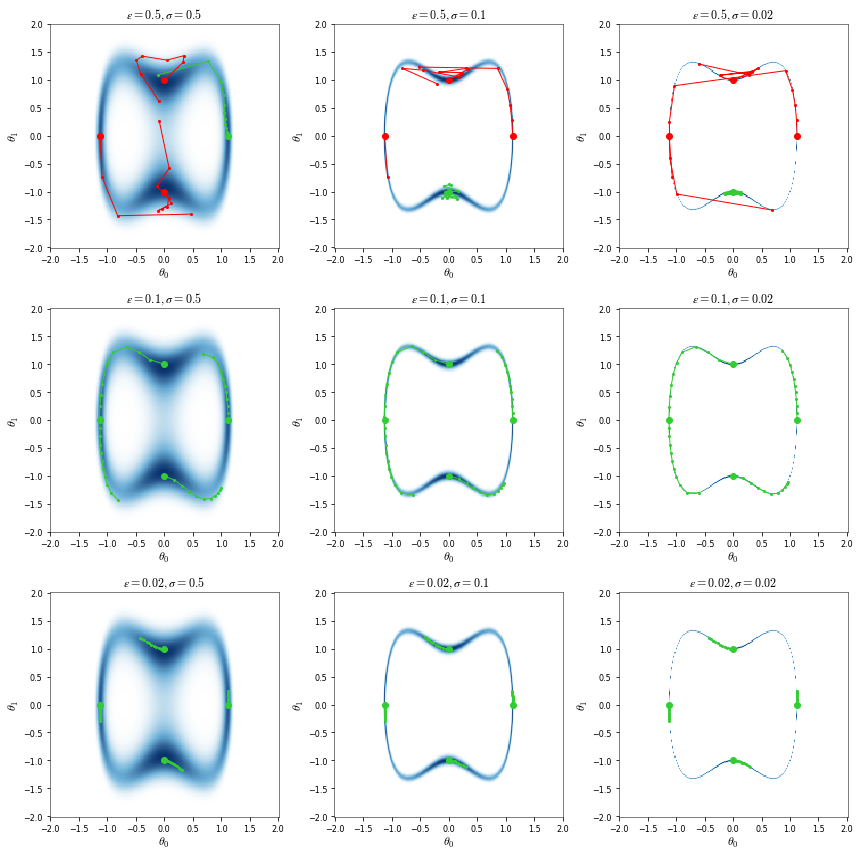

In [44]:
def plot_chmc_proposals(σ=0.1, ϵ=0.1, y=1, n_step=20, n_particle=4, ax=None):
    system = mici.systems.DenseConstrainedEuclideanMetricSystem(
        neg_log_dens=neg_log_prior_dens,
        grad_neg_log_dens=grad_neg_log_prior_dens, 
        dens_wrt_hausdorff=False,
        constr=partial(constr, σ=σ, y=y), 
        jacob_constr=partial(jacob_constr, σ=σ, y=y), 
        mhp_constr=partial(mhp_constr, σ=σ, y=y))
    integrator = mici.integrators.ConstrainedLeapfrogIntegrator(
        system, step_size=ϵ, 
        projection_solver=mici.solvers.solve_projection_onto_manifold_newton)
    states = [mici.states.ChainState(
        pos=np.concatenate([θ, (y - forward_func(θ)) / σ]), mom=None, dir=1) 
        for θ in np.concatenate(solve_for_limiting_manifold(y, n_particle))]
    rng = np.random.default_rng(seed)
    fig, ax = plot_posterior_density(σ, y, ax)
    for state in states:
        plot_trajectory(ax, *simulate_proposal(
            state, system, integrator, rng, n_step))
    
interact_or_grid(
    plot_chmc_proposals, 
    σ=[(0.02, 1., 0.02), (0.5, 0.1, 0.02)], 
    ϵ=[(0.02, 1., 0.02), (0.5, 0.1, 0.02)], 
    y=[(-0.5, 2.), y], 
    n_step=[(10, 100, 10), 10], 
    n_particle=[(4, 10, 2), 4],
    grid_params=('ε', 'σ')
)

In [45]:
chmc_av_accept_probs, chmc_prop_conv_error = np.full(
    (2, σ_grid.shape[0], ϵ_grid.shape[0]), np.nan)

with mici.progressbars.ProgressBar(
        list(enumerate(product(σ_grid, ϵ_grid))), 'Completed') as pb:
    for (i, (σ, ϵ)), _ in pb:
        q_inits = [np.concatenate([θ, (y - forward_func(θ)) / σ]) 
                   for θ in θ_inits]
        system = mici.systems.DenseConstrainedEuclideanMetricSystem(
            neg_log_dens=neg_log_prior_dens,
            grad_neg_log_dens=grad_neg_log_prior_dens, 
            dens_wrt_hausdorff=False,
            constr=partial(constr, σ=σ, y=y), 
            jacob_constr=partial(jacob_constr, σ=σ, y=y), 
            mhp_constr=partial(mhp_constr, σ=σ, y=y))
        integrator = mici.integrators.ConstrainedLeapfrogIntegrator(
            system, step_size=ϵ, 
            projection_solver=mici.solvers.solve_projection_onto_manifold_newton)
        sampler = mici.samplers.StaticMetropolisHMC(
            system, integrator, rng, n_step=n_step)
        _, _, stats = sampler.sample_chains(
            n_sample, q_inits, n_process=n_chain, display_progress=False)
        chmc_av_accept_probs.flat[i] = np.concatenate(
            [a for a in stats['accept_stat']]).mean()
        chmc_prop_conv_error.flat[i] = np.concatenate(
            [a for a in stats['convergence_error']]).mean()

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
_ = plot_statistic_heatmap(σ_grid, ϵ_grid, chmc_av_accept_probs, ax=axes[0], 
                           title='Av. acceptance probability (C-HMC)', 
                           colorbar=False)
_ = plot_statistic_heatmap(σ_grid, ϵ_grid, chmc_prop_conv_error, ax=axes[1], 
                           title='Prop. convergence errors (C-HMC)')

Completed:   0%|          |0/121 [00:00<?, ?]

RemoteError: 
---------------------------------------------------------------------------
Traceback (most recent call last):
  File "/opt/anaconda3/envs/manifold-sampling/lib/python3.10/multiprocessing/managers.py", line 253, in serve_client
    request = recv()
  File "/opt/anaconda3/envs/manifold-sampling/lib/python3.10/multiprocessing/connection.py", line 256, in recv
    return _ForkingPickler.loads(buf.getbuffer())
ModuleNotFoundError: No module named 'symnum_neg_log_prior_dens_module_6gckua0h'
---------------------------------------------------------------------------

# RWM

In [539]:
from RWM import RWM

In [552]:
n_sample = 50
n_chain = 10
rwm_av_accept_probs = np.full((σ_grid.shape[0], ϵ_grid.shape[0]), 0.0)
with mici.progressbars.ProgressBar(
        list(enumerate(product(σ_grid, ϵ_grid))), 'Completed') as pb:
    for (i, (σ, ϵ)), _ in pb:
        for θinit in θ_inits:
            _, acc = RWM(θinit, ϵ, n_sample, lambda θ: -neg_log_posterior_dens(θ, σ=σ, y=y))
        rwm_av_accept_probs.flat[i] += acc.mean() / len(θ_inits)

Completed: 100%|██████████|121/121 [00:00<00:00, 158.63it/s]

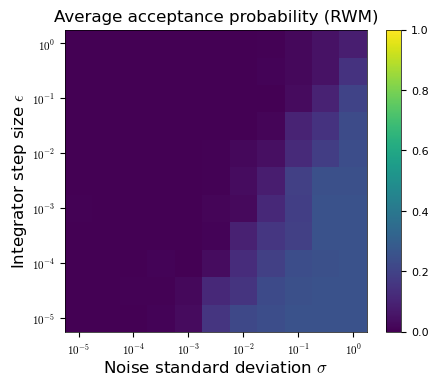

In [553]:
fig, ax = plot_statistic_heatmap(
    σ_grid, ϵ_grid, rwm_av_accept_probs, title='Average acceptance probability (RWM)')

# Hug and Thug

In [554]:
q = MVN(zeros(2), eye(2))

In [555]:
hug_av_accept_probs = np.full((σ_grid.shape[0], ϵ_grid.shape[0]), 0.0)

with mici.progressbars.ProgressBar(
        list(enumerate(product(σ_grid, ϵ_grid))), 'Completed') as pb:
    for (i, (σ, ϵ)), _ in pb:
        for θinit in θ_inits:
            logpi = lambda θ: log_posterior(θ, y=y, σ=σ)
            grad_logpi = lambda θ: grad_log_post(θ, y=y, σ=σ)
            _, acc = Hug(θinit, ϵ * n_step, n_step, n_sample, q, logpi, grad_logpi)
            hug_av_accept_probs.flat[i] += acc.mean() / len(θ_inits)

Completed: 100%|██████████|121/121 [00:09<00:00, 12.84it/s]

In [556]:
from tangential_hug_functions import HugStepEJSD_Deterministic, HugTangentialStepEJSD_Deterministic
from numpy.random import rand

In [623]:
np.random.seed(1234)
n_chain = 10
n_sample = 50
θ_inits = np.concatenate(solve_for_limiting_manifold(y, n_chain))


hug_av_accept_probs = np.full((σ_grid.shape[0], ϵ_grid.shape[0]), 0.0)
thug_av_accept_probs = np.full((σ_grid.shape[0], ϵ_grid.shape[0]), 0.0)
#αs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99] 
#αs = np.r_[0.0, np.logspace(-2.8, 0.3, num=10, endpoint=False)]
#αs = [0.0, 0.0, 0.0, 0.5, 0.8, 0.9, 0.95, 0.99, 0.995, 0.999, 0.99999]

# αs = [0.0, 0.0, 0.0, 0.0, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.95]
# αs = αs[::-1]

#αs[i//len(σ_grid)]

αs = np.array([0.95, 0.95, 0.95, 0.9, 0.9, 0.9, 0.9, 0.9, 0.0, 0.0, 0.0])

with mici.progressbars.ProgressBar(
        list(enumerate(product(σ_grid, ϵ_grid))), 'Completed') as pb:
    for (i, (σ, ϵ)), _ in pb:
        for θinit in θ_inits:
            logpi = lambda θ: log_posterior(θ, y=y, σ=σ)
            grad_logpi = lambda θ: grad_log_post(θ, y=y, σ=σ)
            # Perform Hug and Thug with the same velocities and random seeds
            x_hug  = θinit
            x_thug = θinit
            v0 = q.rvs(n_sample)
            logu = np.log(rand(n_sample))
            acc_hug = []
            acc_thug = []
            α = αs[σ_grid == σ][0] if ϵ == 1.0 else 0.0
            for iii in range(n_sample):
                x_hug, ahug, _, _, _  = HugStepEJSD_Deterministic(x_hug, v0[iii], logu[iii], ϵ * n_step, n_step,q, logpi, grad_logpi)
                x_thug, athug, _, _, _ = HugTangentialStepEJSD_Deterministic(x_thug, v0[iii], logu[iii], ϵ * n_step, n_step, α, q, logpi, grad_logpi)
                acc_hug.append(ahug)
                acc_thug.append(athug)
            hug_av_accept_probs.flat[i] += np.mean(acc_hug) / len(θ_inits)
            thug_av_accept_probs.flat[i] += np.mean(acc_thug) / len(θ_inits)

Completed: 100%|██████████|121/121 [00:46<00:00, 2.60it/s]

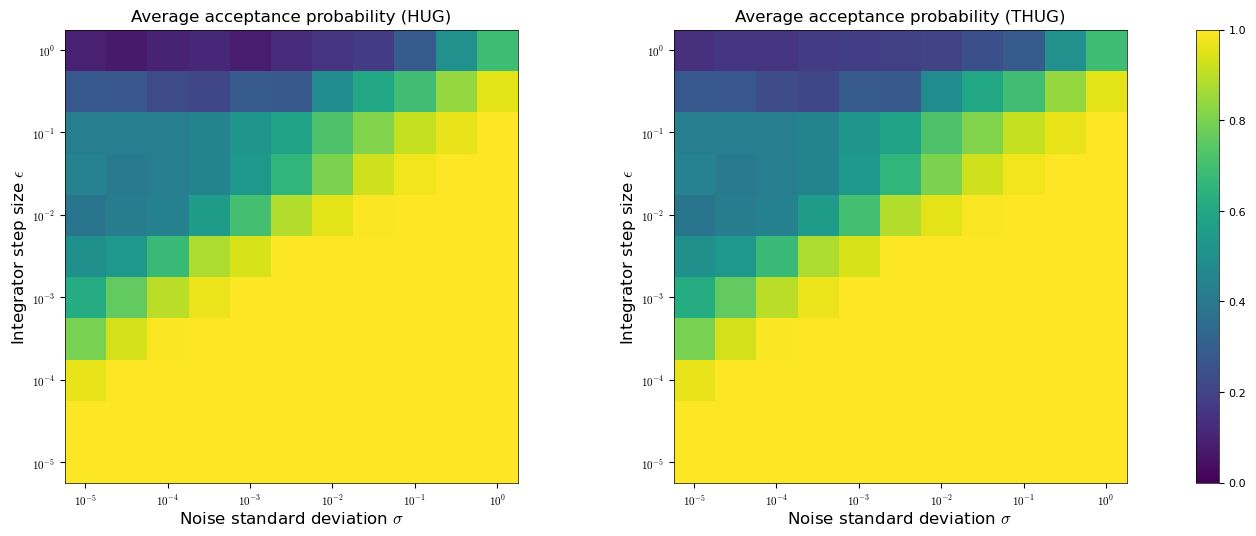

In [624]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
_ = plot_statistic_heatmap(
    σ_grid, ϵ_grid, hug_av_accept_probs, title='Average acceptance probability (HUG)', ax=ax[0])
_ = plot_statistic_heatmap(
    σ_grid, ϵ_grid, thug_av_accept_probs, title='Average acceptance probability (THUG)', ax=ax[1], colorbar=False)

In [645]:
hug_av_accept_probs[:, -2]

array([0.276, 0.272, 0.228, 0.212, 0.286, 0.278, 0.484, 0.594, 0.694,
       0.842, 0.958])

In [625]:
hug_av_accept_probs[:, -1] * 100

array([ 9. ,  7.2,  9.8, 11.6,  8. , 12.2, 15.6, 17.2, 28.6, 50.4, 68.8])

In [627]:
thug_av_accept_probs[:, -1] * 100 #0.95

array([14. , 16. , 15.4, 17.4, 18.2, 19. , 20.4, 24.6, 28.6, 50.4, 68.8])

In [626]:
thug_av_accept_probs[:, -1] * 100 #0.99

array([14. , 16. , 15.4, 17.4, 18.2, 19. , 20.4, 24.6, 28.6, 50.4, 68.8])

In [582]:
thug_av_accept_probs[:, -1] #0.9

array([0.138, 0.156, 0.138, 0.174, 0.182, 0.19 , 0.204, 0.172, 0.286,
       0.504, 0.688])

In [595]:
thug_av_accept_probs[:, -1] #0.95 and 0.95 before too

array([0.14 , 0.16 , 0.154, 0.174, 0.182, 0.19 , 0.204, 0.246, 0.286,
       0.504, 0.688])

In [590]:
αs = np.array([0.95, 0.95, 0.95, 0.9, 0.9, 0.9, 0.9, 0.9, 0.0, 0.0, 0.0])

In [592]:
αs[σ_grid == 1.0][0]

0.0

# Hug and Thug on Lifted Manifold

In [685]:
# Function in θ
F = lambda θ: np.array([θ[1]**2 + 3 * θ[0]**2 * (θ[0]**2 - 1)])

# Function in ξ = [θ, η]
Gσ = lambda ξ, σ: F(ξ[:2]) + σ * ξ[-1]

logprior = lambda ξ: MVN(zeros(3), eye(3)).logpdf(ξ)

def log_epanechnikov_kernel(ξ, ϵ, σ, y):
    u = norm(G(ξ, σ) - y)
    with np.errstate(divide='ignore'):
        return log((3*(1 - (u**2 / (ϵ**2))) / (4*ϵ)) * float(norm(G(ξ, σ) - y) <= ϵ))
    
log_posterior = lambda ξ, ϵ, σ, y: logprior(ξ) + log_epanechnikov_kernel(ξ, ϵ, σ, y)

grad_manifold = lambda ξ, σ: np.array([12*ξ[0]**3 - 6*ξ[0], 2*ξ[1], σ])#np.array([6*ξ[0]*(ξ[1]**2-1), 2*ξ[1] + 3*(ξ[0]**2)*(2*ξ[1] - 1), σ])

In [690]:
q = MVN(zeros(3), eye(3))
hug_av_accept_probs2 = np.full((σ_grid.shape[0], ϵ_grid.shape[0]), 0.0)

with mici.progressbars.ProgressBar(
        list(enumerate(product(σ_grid, ϵ_grid))), 'Completed') as pb:
    for (i, (σ, ϵ)), _ in pb:
        ξ_inits = [np.concatenate([θ, (y - forward_func(θ)) / σ]) for θ in θ_inits]
        for ξinit in ξ_inits:
            logpi = lambda ξ: log_posterior(ξ, ϵ=0.02, σ=σ, y=y)
            grad_logpi = lambda ξ: grad_manifold(ξ, σ=σ)
            _, acc = Hug(ξinit, ϵ * n_step, n_step, n_sample, q, logpi, grad_logpi)
            hug_av_accept_probs2.flat[i] += acc.mean() / len(ξ_inits)

Completed: 100%|██████████|121/121 [00:22<00:00, 5.29it/s]

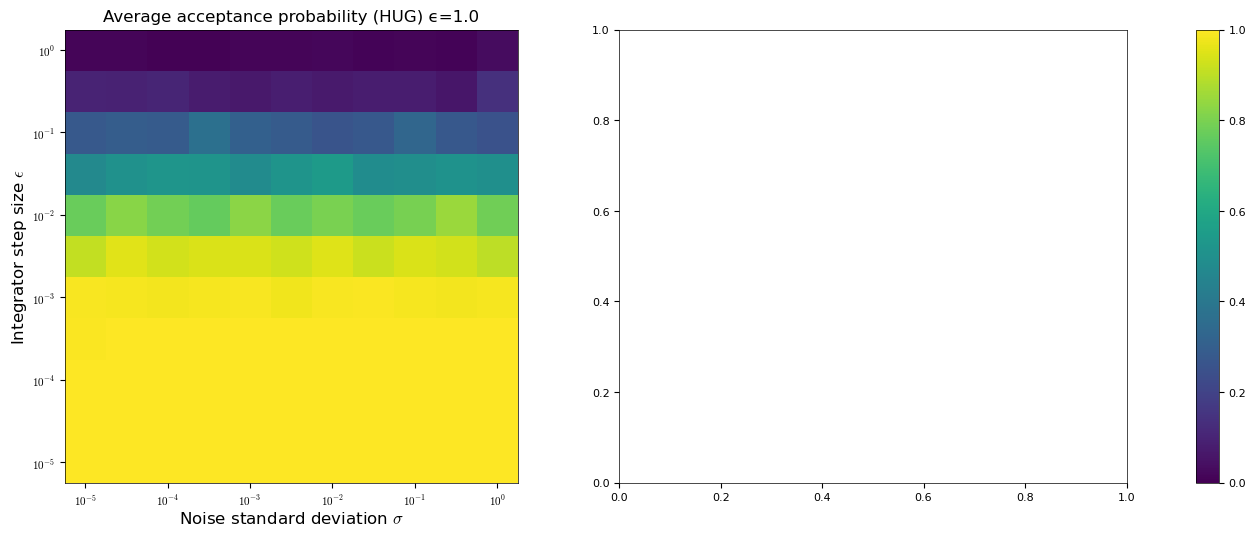

In [676]:
# ϵ = 1.0
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
_ = plot_statistic_heatmap(
    σ_grid, ϵ_grid, hug_av_accept_probs2, title='Average acceptance probability (HUG) ϵ=1.0', ax=ax[0])

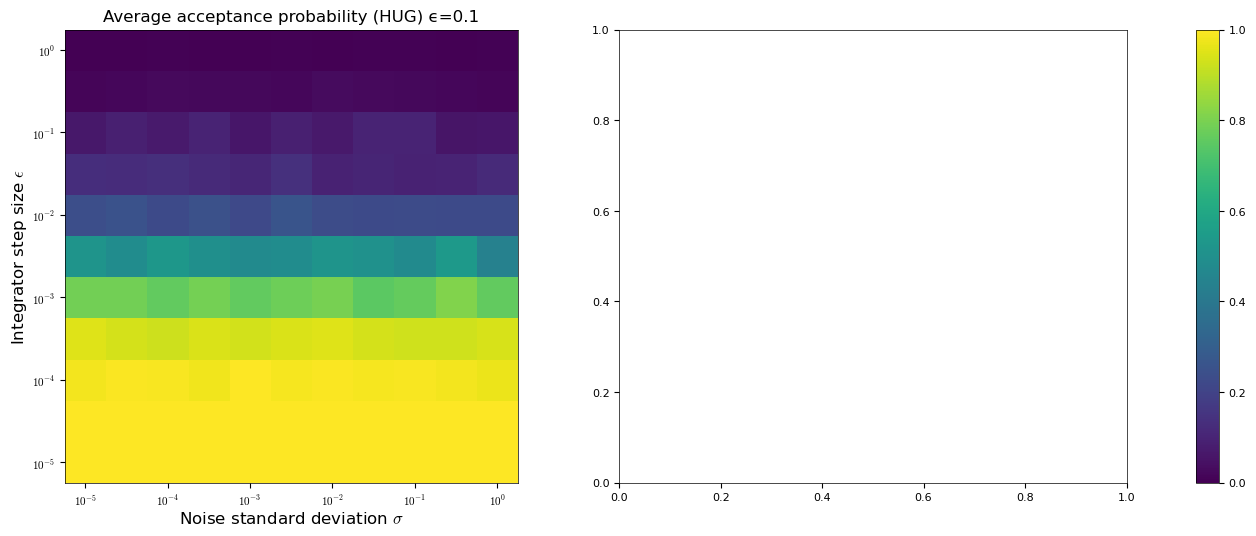

In [682]:
# ϵ = 0.1
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
_ = plot_statistic_heatmap(
    σ_grid, ϵ_grid, hug_av_accept_probs2, title='Average acceptance probability (HUG) ϵ=0.1', ax=ax[0])

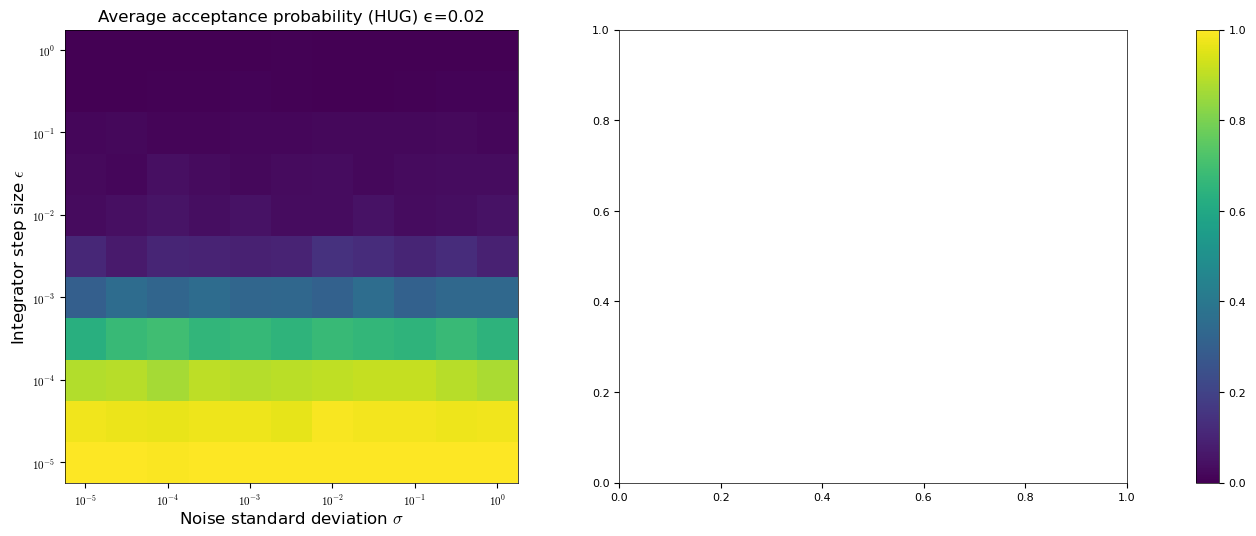

In [684]:
# ϵ = 0.02
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
_ = plot_statistic_heatmap(
    σ_grid, ϵ_grid, hug_av_accept_probs2, title='Average acceptance probability (HUG) ϵ=0.02', ax=ax[0])

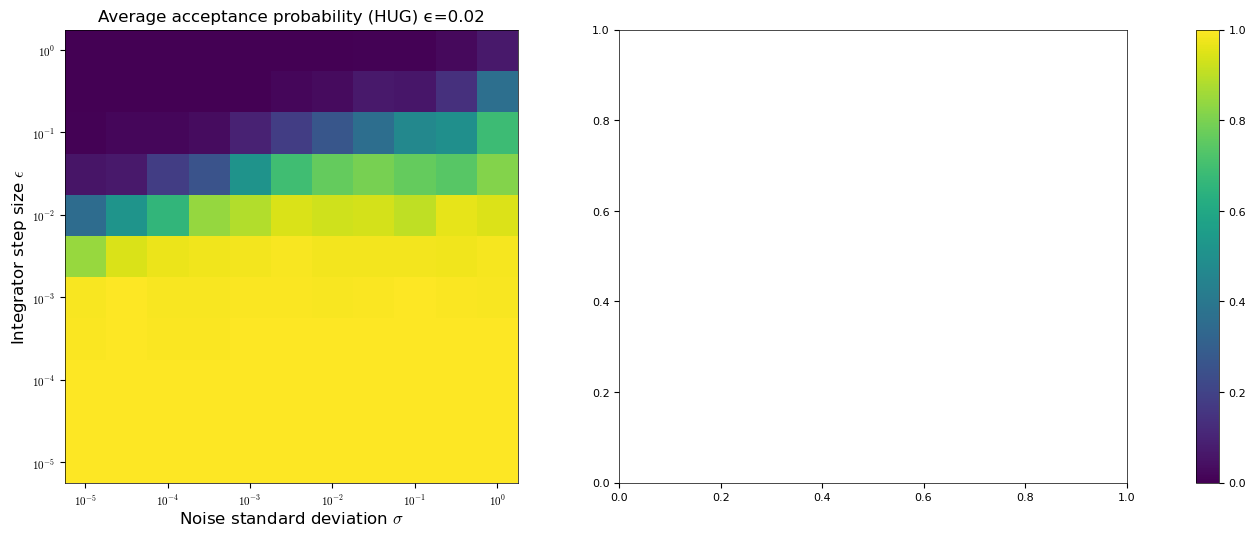

In [689]:
# ϵ = 0.02
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
_ = plot_statistic_heatmap(
    σ_grid, ϵ_grid, hug_av_accept_probs2, title='Average acceptance probability (HUG) ϵ=0.02', ax=ax[0])

In [696]:
σ_grid


array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00])

In [697]:
ϵ_grid

array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00])

In [715]:
ξ_init = np.concatenate([θ_inits[0], (y - forward_func(θ_inits[0])) / 0.02])
logpi = lambda ξ: log_posterior(ξ, ϵ=0.02, σ=0.02, y=y)
grad_logpi = lambda ξ: grad_manifold(ξ, σ=0.02)
sam, acc = Hug(ξ_init, ϵ_grid[0] * n_step, n_step, n_sample, q, logpi, grad_logpi)

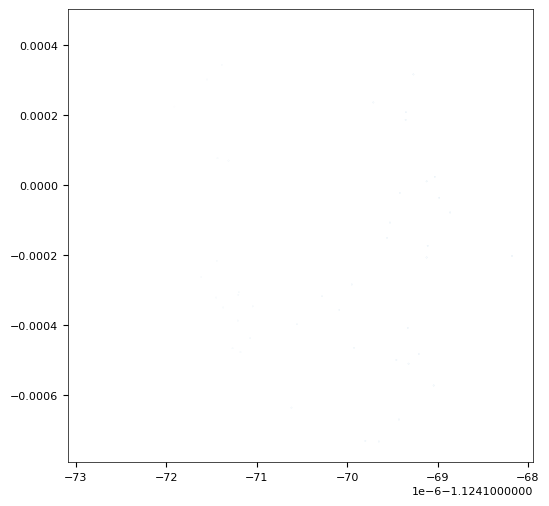

In [716]:
plt.scatter(*sam.T)

# Using C-HMC on $\overline{p}(\theta\mid y)$

$$
\overline{p}(\theta\mid y) = \lim_{\sigma\to 0} p_\sigma(\theta\mid y)
$$

$$
\overline{p}(\theta\mid y) \mathcal{H}(d\theta) = p(\theta)|J_h(\theta) J_h(\theta)^\top|^{-1/2}\mathcal{H}(d\theta)
$$

In [ ]:
@numpify(dim_θ, None, None)
def neg_log_posterior_dens(θ, σ, y):
    return (snp.sum(θ**2, 0) + snp.sum((y - forward_func(θ))**2, 0) / σ**2) / 2

In [ ]:
@numpify(dim_θ, None, None, None)
def neg_log_lifted_posterior_dens(θ, η, σ, y):
    jac = jacobian(forward_func)(θ)
    return snp.sum(θ**2, 0) / 2 + η**2 / 2 + snp.log(jac @ jac.T + σ**2)[0, 0] / 2

In [56]:
@numpify(dim_θ, None)
def neg_log_pbar_dens(θ, y):
    jac = jacobian(forward_func)(θ)
    return snp.sum(θ**2, 0)/2 + snp.log(jac @ jac.T)[0, 0] / 2

grad_neg_log_pbar_dens = grad(neg_log_pbar_dens)

In [69]:
@numpify(dim_θ, None)
def constr_h(θ, y):
    return forward_func(θ) - y

jacob_constr_h = jacobian(constr_h, return_aux=True)
mhp_constr_h   = matrix_hessian_product(constr_h, return_aux=True)

AttributeError: 'numpy.ndarray' object has no attribute 'atoms'

In [73]:
system = mici.systems.DenseConstrainedEuclideanMetricSystem(
            neg_log_dens=neg_log_pbar_dens,
            grad_neg_log_dens=grad_neg_log_pbar_dens, 
            dens_wrt_hausdorff=False,
            constr=partial(constr_h, y=y), 
            jacob_constr=partial(jacob_constr_h, y=y), 
            mhp_constr=partial(mhp_constr_h, y=y))

integrator = mici.integrators.ConstrainedLeapfrogIntegrator(
    system, step_size=1.00000000e-02, 
    projection_solver=mici.solvers.solve_projection_onto_manifold_newton)

sampler = mici.samplers.StaticMetropolisHMC(
            system, integrator, rng, n_step=n_step)

In [77]:
sampler.rng

Generator(PCG64) at 0x13C5EA260

In [76]:
q_inits[0]

array([-1.12417197e+00, -1.50494351e-07])

In [79]:
super(sampler.system)  #sample_momentum(q_inits[0], sampler.rng)

TypeError: super() argument 1 must be type, not DenseConstrainedEuclideanMetricSystem

In [80]:
sampler.system.jacob_constr(q_inits[0])

AttributeError: 'numpy.ndarray' object has no attribute '_cache'

In [75]:
sampler._preprocess_init_state(q_inits[0])

TypeError: 'int' object is not subscriptable

In [74]:
_, _, stats = sampler.sample_chains(
    n_sample, q_inits, n_process=n_chain, display_progress=False)

TypeError: 'int' object is not subscriptable

In [68]:
chmc_apbar_v_accept_probs, chmc_pbar_prop_conv_error = np.full(
    (2, σ_grid.shape[0], ϵ_grid.shape[0]), np.nan)

with mici.progressbars.ProgressBar(
        list(enumerate(product(σ_grid, ϵ_grid))), 'Completed') as pb:
    for (i, (σ, ϵ)), _ in pb:
        q_inits = θ_inits
        system = mici.systems.DenseConstrainedEuclideanMetricSystem(
            neg_log_dens=neg_log_pbar_dens,
            grad_neg_log_dens=grad_neg_log_pbar_dens, 
            dens_wrt_hausdorff=False,
            constr=partial(constr_h, y=y), 
            jacob_constr=partial(jacob_constr_h, y=y), 
            mhp_constr=partial(mhp_constr_h, y=y))
        integrator = mici.integrators.ConstrainedLeapfrogIntegrator(
            system, step_size=ϵ, 
            projection_solver=mici.solvers.solve_projection_onto_manifold_newton)
        sampler = mici.samplers.StaticMetropolisHMC(
            system, integrator, rng, n_step=n_step)
        _, _, stats = sampler.sample_chains(
            n_sample, q_inits, n_process=n_chain, display_progress=False)
        chmc_apbar_v_accept_probs.flat[i] = np.concatenate(
            [a for a in stats['accept_stat']]).mean()
        chmc_pbar_prop_conv_error.flat[i] = np.concatenate(
            [a for a in stats['convergence_error']]).mean()

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
_ = plot_statistic_heatmap(σ_grid, ϵ_grid, chmc_apbar_v_accept_probs, ax=axes[0], 
                           title='Av. acceptance probability (C-HMC)', 
                           colorbar=False)
_ = plot_statistic_heatmap(σ_grid, ϵ_grid, chmc_pbar_prop_conv_error, ax=axes[1], 
                           title='Prop. convergence errors (C-HMC)')

Completed:   0%|          |0/121 [00:00<?, ?]

TypeError: 'int' object is not subscriptable